In [ ]:
!pip install tulipy # library to compute technical indicators
!pip install stable_baselines3=='0.11.0'
!pip install torch=='1.8.1'
!pip install numpy=='1.19.5' #library for reinforcement learning https://stable-baselines3.readthedocs.io/en/master/guide/quickstart.html
!git clone https://github.com/EmaChiari/Thesis.git

     |████████████████████████████████| 112kB 3.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for tulipy: filename=tulipy-0.4.0-cp37-cp37m-linux_x86_64.whl size=227742 sha256=a441f589e707ac5e8d2f4ee0f3f577ba9bfe854d99db0e0742c828b54c28edbb
  Stored in directory: /root/.cache/pip/wheels/c7/17/ad/a187769379c3b970acfd4aabe82e8e2b4dfca2b518a26de957
Successfully built tulipy
     |████████████████████████████████| 153kB 2.8MB/s 
Cloning into 'Thesis'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 161 (delta 39), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (161/161), 76.81 MiB | 11.22 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import tulipy as ti 
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import sys
import os

from sklearn.preprocessing import MinMaxScaler
#list of technical indicators used 
INDICATORS_LIST = ["macd","boll_ub","boll_lb","rsi_30", "cci_30", "dx_30","sma_30","sma_60","aroon_up","aroon_down","adosc"]

In [ ]:
#list of the secutrities that compose the index at 2019/01
FTSE_MIB_TICKER = ['ERNE.MI','JUVE.MI','CPR.MI','PST.MI','MONC.MI','AMP.MI','FBK.MI','TRN.MI','A2A.MI','US.MI','ENI.MI','RACE.MI','ENEL.MI','IG.MI','DIA.MI','G.MI','SRG.MI','EXO.MI','UNI.MI','SPM.MI','REC.MI','BPE.MI','SFER.MI','MB.MI','LDO.MI','PIRC.MI','BAMI.MI','TEN.MI','CNHI.MI','BRE.MI','ISP.MI','ATL.MI','STM.MI','TIT.MI','BZU.MI','BGN.MI','PRY.MI','UCG.MI','AZM.MI'] 

In [ ]:
class PreprocessData:

    def __init__(self,split_date:str, ticker_list: list):

        
        self.ticker_list = ticker_list
        self.split_date = split_date
    # functions that use the Tulip library to compute the technical indicators https://tulipindicators.org/
    #simple moving average
    def get_sma(self,column,days=30):
        x = column.values
        sma = ti.sma(x,period=days)
        zeros = np.zeros((days-1))
        res = np.concatenate([zeros,sma],axis=0)
        return res
    #moving average convergence divergence 
    def get_macd(self,column,n1=2,n2=5,n3=9):
        x = column.values
        macd,_,_ = ti.macd(x,n1,n2,n3)
        zeros = np.zeros((n2-1))
        res = np.concatenate([zeros,macd],axis=0)
        return res
    # bollinger bands
    def get_bband(self,column,period=5,std = 2):
        x = column.values
        lower,_,upper = ti.bbands(x,period,std)
        zeros = np.zeros((period-1))
        res_l = np.concatenate([zeros,lower],axis=0)
        res_u = np.concatenate([zeros,upper],axis=0)
        return res_l,res_u
    #Relative strength index
    def get_rsi(self,column,period=30):
        x = column.values
        rsi = ti.rsi(x,period)
        zeros = np.zeros((period))
        res = np.concatenate([zeros,rsi],axis=0)
        return res
    #commodity channel index 
    def get_cci(self,high,low,close,period=30):
        x = high.values
        n1 = len(x)
        y = low.values
        z = close.values
        cci = ti.cci(x,y,z,period)
        n2 = len(cci)
        zeros = np.zeros((n1-n2))
        res = np.concatenate([zeros,cci],axis=0)
        return res
    #directional movement index 
    def get_dx(self,high,low,close,period=30):
        x = high.values
        y = low.values
        z = close.values
        dx = ti.dx(x,y,z,period)
        zeros = np.zeros((period-1))
        res = np.concatenate([zeros,dx],axis=0)
        return res
    # aroon
    def get_aroon(self,high,low,period=20):
        x = high.values
        y = low.values
        aroon_down,aroon_up = ti.aroon(x,y,period)
        zeros = np.zeros((period))
        aroon_down = np.concatenate([zeros,aroon_down],axis=0)
        aroon_up = np.concatenate([zeros,aroon_up],axis=0)
        return aroon_down,aroon_up
    #Accumulation distribution oscillator 
    def get_adosc(self,high,low,close,volume,n1=10,n2=20):
        x = high.values
        y = low.values
        z = close.values
        w = volume.values*1.0 
        adosc = ti.adosc(x,y,z,w,n1,n2)
        zeros = np.zeros((n2-1))
        res = np.concatenate([zeros,adosc],axis=0)
        return res 
    
    #function that adds the covariance matrix fo the returns over the past year 
    def add_cov(self,df,p=252):
        
        covariances = []
        df.index = df.date.factorize()[0]

        
        

        for i in range(p,len(df.index.unique())):
            df_p = df.loc[i-p:i,:]
            price_p=df_p.pivot_table(index = 'date',columns = 'tic', values = 'close')
            return_p = price_p.pct_change().dropna()
            covariance = return_p.cov().values 
            covariances.append(covariance)
  
        df_cov = pd.DataFrame({'date':df.date.unique()[p:],'Covariances':covariances })
        df = df.merge(df_cov, on='date')
        df = df.sort_values(['date','tic']).reset_index(drop=True)
        print("Added covariance matrix")
        return df 



    


   #splits the data in train and test dataset 
    def train_test(self,data):
      df_training = data.loc[data['date'] <= self.split_date]
      df_test = data.loc[data['date'] > self.split_date]
      
      df_training.index = df_training.date.factorize()[0]
      df_test.index = df_test.date.factorize()[0]
      
      return df_training , df_test

    #normalizes the train and test data  
    def normalize(self,train,test):
      
      train_l = []
      test_l = []
      for i in np.unique(train.tic):
        
        df_train = train[train.tic==i].copy()
        df_test = test[test.tic==i].copy()
        scaler = MinMaxScaler()
        scaler = scaler.fit(df_train[INDICATORS_LIST])
        df_train[INDICATORS_LIST] = scaler.transform(df_train[INDICATORS_LIST])
        df_test[INDICATORS_LIST] = scaler.transform(df_test[INDICATORS_LIST])

        train_l.append(df_train)
        test_l.append(df_test)
      
      train = pd.concat(train_l)
      train = train.sort_values(by=['date','tic']).reset_index(drop=True)
      train.index = train.date.factorize()[0]

      test = pd.concat(test_l)
      test = test.sort_values(by=['date','tic']).reset_index(drop=True)
      test.index = test.date.factorize()[0]




      
      
      print("Normalized data")
      return train,test


    def process_data(self):
        l = []
        
        columns = ["date","open","high","low","close","adjcp","volume","tic",]
        for tic in self.ticker_list:
            
            temp_df = pd.read_csv("/content/Thesis/FTSE_MIB_Data/"+tic[:-3]+".csv", index_col = 0)
            
            temp_df["tic"] = tic
            temp_df.reset_index(inplace=True)
            
            temp_df['Date'] = pd.to_datetime(temp_df['Date'], errors='coerce')
            temp_df.columns = columns
            temp_df["close"] = temp_df["adjcp"]
            temp_df = temp_df.drop("adjcp", 1)
            temp_df["day"] = temp_df["date"].dt.dayofweek
            temp_df["date"] = temp_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
            temp_df = temp_df.dropna()
            temp_df = temp_df.reset_index(drop=True)
           
            temp_df['sma_30'] = self.get_sma(temp_df['close'])
            temp_df['sma_60'] = self.get_sma(temp_df['close'],60)
            temp_df['macd'] = self.get_macd(temp_df['close'])
            
            temp_df['boll_lb'],temp_df['boll_ub'] = self.get_bband(temp_df['close'])
            
            temp_df['rsi_30'] = self.get_rsi(temp_df['close'])
            
            temp_df['cci_30'] = self.get_cci(temp_df['high'],temp_df['low'],temp_df['close'])

            temp_df['dx_30'] = self.get_dx(temp_df['high'],temp_df['low'],temp_df['close'])
            
            temp_df['adosc'] = self.get_adosc(temp_df['high'],temp_df['low'],temp_df['close'],temp_df['volume'])

            temp_df['aroon_down'],temp_df['aroon_up'] = self.get_aroon(temp_df['high'],temp_df['low'])
            #fill potential remaining nans 
            temp_df = temp_df.bfill()
            
            l.append(temp_df)

        fin_data = pd.concat(l)
        fin_data = fin_data.sort_values(by=['date','tic']).reset_index(drop=True)
        fin_data = self.add_cov(fin_data)
        train,test=self.train_test(fin_data)
        train,test=self.normalize(train,test)


        return train,test
        

In [ ]:
train,test = PreprocessData(split_date='2019-01-01', ticker_list = FTSE_MIB_TICKER ).process_data()

Added covariance matrix
Normalized data


In [ ]:
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv

class StockPortfolioEnv(gym.Env):
    
    metadata = {'render.modes': ['human']}

    def __init__(self,data,n_stocks,initial_amount,trans_cost,indicators,test = False):
        #initialization of the environment 
        self.test = test
        self.cost_tot = 0 
        

        self.data = data
        self.n_stocks = n_stocks
        self.initial_amount = initial_amount
        self.trans_cost =trans_cost
        
        self.indicators = indicators
        
        #randomize the start of the episode as mentioned before
        if test :
          self.day = 0
          self.diff = "Test"
        else :
          max_l = len(self.data.index.unique())-1
          end = int(0.8*max_l)
          self.day = np.random.randint(0,end)
          self.diff = self.day

        # we define the action space as the weights of the various assets in the portfolio 
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.n_stocks,)) 
        # observation space = covariance matrix + technical indicators for each of the securities observed 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.n_stocks +len(self.indicators),self.n_stocks))

        # load data from a pandas dataframe
        
        self.daily_values = self.data.loc[self.day,:]
        self.covs = self.daily_values['Covariances'].values[0]
        
        
        self.state =  np.append(np.array(self.covs), [self.daily_values[tech].values.tolist() for tech in self.indicators ], axis=0)
        self.terminal = False     
                
        # initalize value of the portfolio 
        self.portfolio_value = self.initial_amount
        
        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        
        self.portfolio_return_memory = [0]
        #first action = all money in the proxy for cash 
        self.actions_memory= [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
        self.date_memory=[self.daily_values.date.unique()[0]]

        
    def step(self, actions):
        #if we reach the last available day end the episode
        self.terminal = self.day >= len(self.data.index.unique())-1
       

        if self.terminal:
            data = pd.DataFrame(self.portfolio_return_memory)
            data.columns = ['daily_return']

            print("*********************************")
            print("Start Assets:{}".format(self.asset_memory[0]))           
            print("Final Assets:{}".format(self.portfolio_value))
            r = ((self.portfolio_value-self.asset_memory[0])/self.asset_memory[0])
            print(" % Return: {}".format(r*100))
            print("Start Day: {}".format(self.diff))
            print("*********************************")
            
            
            return self.state, self.reward, self.terminal,{}

        else:
            #otherwise we perform a time step 
            #fisrt we normalize the action such that they are between 0 and 1 and sum to 1 
            w = self.softmax(actions) 
            
            
            #we save the old weights 
            old_w = self.actions_memory[-1]
            
            self.actions_memory.append(w)
            last_day_memory = self.daily_values
            #we calculate the cost 
            cost = sum(np.absolute(w-old_w)*self.asset_memory[-1]*self.trans_cost)
            #we update the state
            self.day += 1
            self.daily_values = self.data.loc[self.day,:]
            self.covs = self.daily_values['Covariances'].values[0]
            self.state =  np.append(np.array(self.covs), [self.daily_values[tech].values.tolist() for tech in self.indicators ], axis=0)
            
            #we calculate the portfolio return 
            portfolio_return = (sum(((self.daily_values.close.values / last_day_memory.close.values)-1)*w))
            
            
            self.portfolio_value = self.portfolio_value - cost
            # from the portfolio value we substract the transaction fees owed after selling or buying securities 
            self.cost_tot = self.cost_tot + cost
            #we get the new portfolio value by multiplying the value of the portfolio at the step before by the returns
            new_portfolio_value = (self.portfolio_value)*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value 
            

            # save into memory
            
            
            self.date_memory.append(self.daily_values.date.unique()[0])            
            

            # the reward is the daily return 
            daily_return = (new_portfolio_value/self.asset_memory[-1])-1
            self.portfolio_return_memory.append(daily_return)
            self.asset_memory.append(new_portfolio_value)
            
            self.reward = daily_return
            
            

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        
        #similar to init we reset the environment at the beginning of each new episode
        
        self.cost_tot = 0 
        self.asset_memory = [self.initial_amount]
        if self.test :
          self.day = 0
          self.diff = "Test"
        else :
          max_l = len(self.data.index.unique())-1
          
          end = int(0.8*max_l)
          
          self.day = np.random.randint(0,end)
          self.diff = self.day
        self.daily_values = self.data.loc[self.day,:]
        
      
        self.covs = self.daily_values['Covariances'].values[0]
        
        
        self.state =  np.append(np.array(self.covs), [self.daily_values[tech].values.tolist() for tech in self.indicators ], axis=0)
        self.portfolio_value = self.initial_amount
        
        self.terminal = False 
        self.portfolio_return_memory = [0]
        
        self.actions_memory= [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
        self.date_memory=[self.daily_values.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
    # various helper functions    
    def softmax(self, actions):
        num = np.exp(actions)
        den = np.sum(np.exp(actions))
        output = num/den
        return output
    
    def save_return_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        
        data_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return data_account_value

    
        
        
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]    

  

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs


In [ ]:
n_stocks = len(train.tic.unique())
env_kwargs_simple = {
    
    "initial_amount": 1000000, 
    "trans_cost": 0.002, 
    "n_stocks": n_stocks, 
    "indicators": INDICATORS_LIST, 
    
    
    
}
env_kwargs_test = {
    
    "initial_amount": 1000000, 
    "trans_cost": 0.002, 
    "n_stocks": n_stocks, 
    "indicators": INDICATORS_LIST, 
    "test": True
    
    
}





#Agents

The following class implements some reinforcment algorithms form the stable-baseline library that could be applicable to this problem.



In [ ]:
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


MODELS = {"a2c": A2C, "td3": TD3, "ppo": PPO}


class Agent:
    
    def __init__(self, env):
        self.env = env
    
    # returns the daily return during the testing 
    @staticmethod
    def predict(model, environment):
        test_env, test_obs = environment.get_sb_env()
        
        return_memory = []
        
        test_env.reset()
        for i in range(len(environment.data.index.unique())):
            action, _states = model.predict(test_obs)
            return_memory = test_env.env_method(method_name="save_return_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if dones[0]:
                print("Finished")
                break
        return return_memory[0]

    
    #builds the model using the various parameters as input 
    def get_model(self,model_name,policy="MlpPolicy",policy_kwargs=None,model_kwargs=None,verbose=1):
        
        print(model_kwargs)
        
        model = MODELS[model_name](
            policy=policy,
            env=self.env,
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            **model_kwargs,
        )
        return model

    def train_model(self, model,total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps)
        return model

In [ ]:
from stable_baselines3.common.env_util import make_vec_env
env_to_vec_simple = StockPortfolioEnv(data = train, **env_kwargs_simple)

#A2C 


In [ ]:
import torch as th 

env_a2c = make_vec_env(lambda: env_to_vec_simple, n_envs=1,seed=0)

agent = Agent(env = env_a2c)

#defines the structure of the neural network
policy_kwargs = dict(activation_fn=th.nn.ReLU,net_arch=[500,dict(pi=[150,64,32], vf=[150,64,32])])

#various parameters like entropy coefficient and seed 
A2C_PARAMS = {"n_steps": 9, "ent_coef": 0.005, "learning_rate": 0.023,"seed":0}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS,policy_kwargs= policy_kwargs)
trained_a2c = agent.train_model(model=model_a2c,total_timesteps=10000)

{'n_steps': 9, 'ent_coef': 0.005, 'learning_rate': 0.023, 'seed': 0}
Using cpu device
*********************************
Start Assets:1000000
Final Assets:1176632.7642060837
 % Return: 17.663276420608373
Start Day: 684
*********************************
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 585      |
|    ep_rew_mean        | 0.208    |
| time/                 |          |
|    fps                | 204      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 900      |
| train/                |          |
|    entropy_loss       | -60      |
|    explained_variance | -0.183   |
|    learning_rate      | 0.023    |
|    n_updates          | 99       |
|    policy_loss        | -21      |
|    std                | 1.18     |
|    value_loss         | 0.138    |
------------------------------------
*********************************
Start Assets:1000000
Final Assets:877737.3321635

In [ ]:
df_daily_return_a2c = Agent.predict(model=trained_a2c,environment= StockPortfolioEnv(data = test, **env_kwargs_test))

*********************************
Start Assets:1000000
Final Assets:1483626.0782017226
 % Return: 48.36260782017226
Start Day: Test
*********************************
Finished


#PPO 

In [ ]:
PPO_param =  {'n_steps': 2000, 'gamma': 0.93, 'learning_rate': 0.013, 'ent_coef': 9.6234e-06,'batch_size':100,'seed':0}


env_ppo = make_vec_env(lambda: env_to_vec_simple, n_envs=1,seed=0)


agent = Agent(env = env_ppo)
policy_kwargs = dict(activation_fn=th.nn.ReLU,net_arch=[500,dict(pi=[150,64,32], vf=[150,64,32])])
model_ppo = agent.get_model("ppo",model_kwargs = PPO_param,policy_kwargs= policy_kwargs)
model_ppo.learn(20000)

{'n_steps': 2000, 'gamma': 0.93, 'learning_rate': 0.013, 'ent_coef': 9.6234e-06, 'batch_size': 100, 'seed': 0}
Using cpu device
*********************************
Start Assets:1000000
Final Assets:722049.1027352774
 % Return: -27.79508972647226
Start Day: 684
*********************************
*********************************
Start Assets:1000000
Final Assets:636505.7104763987
 % Return: -36.34942895236013
Start Day: 559
*********************************
*********************************
Start Assets:1000000
Final Assets:702447.4406209622
 % Return: -29.75525593790378
Start Day: 629
*********************************
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 645      |
|    ep_rew_mean        | -0.326   |
| time/                 |          |
|    fps                | 372      |
|    iterations         | 1        |
|    time_elapsed       | 5        |
|    total_timesteps    | 2000     |
| train/                |          |
|    en

In [ ]:
df_daily_return_ppo = Agent.predict(model= model_ppo,environment= StockPortfolioEnv(data = test, **env_kwargs_test))

*********************************
Start Assets:1000000
Final Assets:1484671.5096592505
 % Return: 48.46715096592505
Start Day: Test
*********************************
Finished


#TD3 

In [ ]:
env_td3_simple = make_vec_env(lambda: env_to_vec_simple, n_envs=1,seed=0)


agent = Agent(env = env_td3_simple)
#guassian noise added to each action 
action_noise = NormalActionNoise(mean=np.zeros(n_stocks), sigma=0.1 * np.ones(n_stocks))
policy_kwargs = dict(net_arch=dict(pi=[400, 300], qf=[400, 300]))
TD3_PARAMS = {"batch_size": 128, "buffer_size": 15000, "learning_rate": 0.075,"seed":2,"action_noise":action_noise,"learning_starts":100}
model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS,policy_kwargs=policy_kwargs)

{'batch_size': 128, 'buffer_size': 15000, 'learning_rate': 0.075, 'seed': 2, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1]), 'learning_starts': 100}
Using cpu device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, total_timesteps=25000)

*********************************
Start Assets:1000000
Final Assets:1158203.6021793194
 % Return: 15.820360217931936
Start Day: 168
*********************************
*********************************
Start Assets:1000000
Final Assets:980367.667786525
 % Return: -1.963233221347502
Start Day: 392
*********************************
*********************************
Start Assets:1000000
Final Assets:892126.8207974043
 % Return: -10.787317920259573
Start Day: 930
*********************************
*********************************
Start Assets:1000000
Final Assets:1063067.1892989753
 % Return: 6.306718929897529
Start Day: 425
*********************************
---------------------------------------------
| rollout/                |                 |
|    ep_len_mean          | 790             |
|    ep_rew_mean          | 0.0949          |
| time/                   |                 |
|    episodes             | 4               |
|    fps                  | 13              |
|    time_elapsed

In [ ]:
df_daily_return_td3 = Agent.predict(model= model_td3,environment= StockPortfolioEnv(data = test, **env_kwargs_test))

*********************************
Start Assets:1000000
Final Assets:1456980.9596460783
 % Return: 45.69809596460782
Start Day: Test
*********************************
Finished


#Results

In [ ]:
benchmark = pd.read_csv("/content/Thesis/FTSE_MIB_Data/Buy_and_hold.csv", index_col = 0)
def sharpe(x):
  return np.sqrt(len(x))*(x.mean()/x.std())

In [ ]:
df_plot = pd.DataFrame()
cum_return_ppo = (1+df_daily_return_ppo['daily_return']).cumprod().to_numpy()
cum_return_a2c = (1+df_daily_return_a2c['daily_return']).cumprod().to_numpy()
cum_return_td3 = (1+df_daily_return_td3['daily_return']).cumprod().to_numpy()
cum_return_djia = (1+benchmark['Adj Close']).cumprod().to_numpy()
df_plot['PPO'] = cum_return_ppo
df_plot['A2C'] = cum_return_a2c
df_plot['TD3'] = cum_return_td3
df_plot['Benchmark'] = cum_return_djia

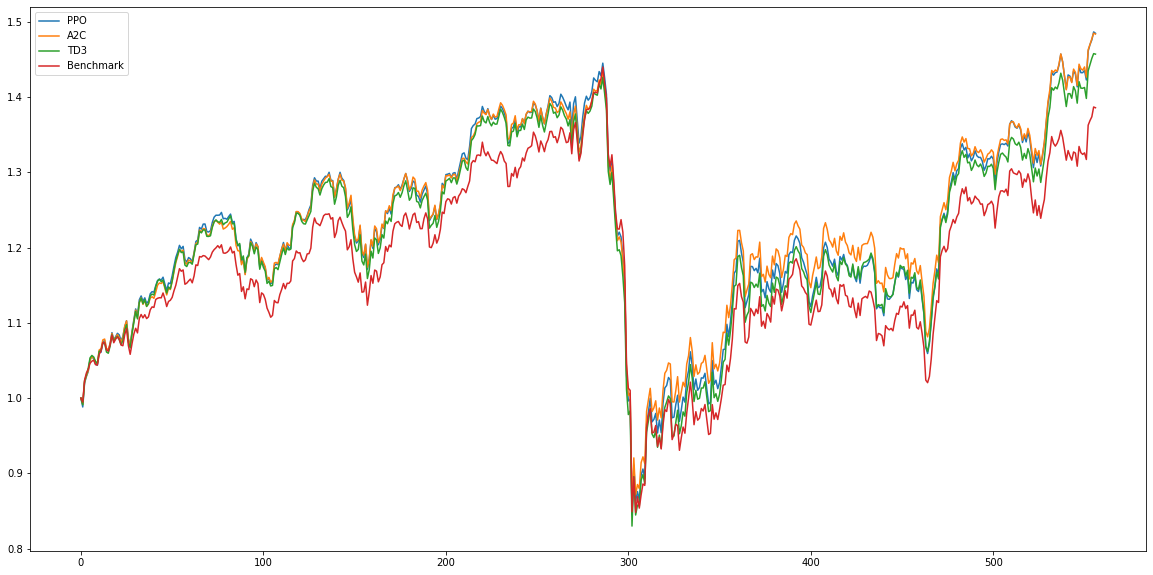

In [ ]:
%matplotlib inline
df_plot.plot(figsize=(20,10))
plt.show()

In [ ]:
sharpe_r = []
sharpe_r.append(sharpe(benchmark["Adj Close"]))
sharpe_r.append(sharpe(df_daily_return_a2c['daily_return']))
sharpe_r.append(sharpe(df_daily_return_ppo['daily_return']))
sharpe_r.append(sharpe(df_daily_return_td3['daily_return']))


In [ ]:
sharpe_r

[1.0618580310187404,
 1.2415060239098081,
 1.2216366725931715,
 1.1743496535577993]

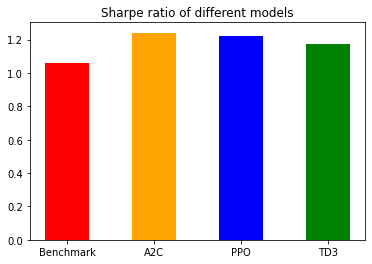

In [ ]:
labels = ["Benchmark","A2C","PPO","TD3"]
x_pos = [i for i, _ in enumerate(labels)]

plt.bar(x_pos, sharpe_r, color=['red','orange','blue','green'],width= 0.5)
plt.title("Sharpe ratio of different models")
plt.xticks(x_pos, labels)



plt.show()